In [50]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# !pip install demoji
import demoji
import pandas as pd
import random
from dataclasses import dataclass
import numpy as np
import torch
# import seaborn as sns
import transformers
import json
import glob
from tqdm import tqdm
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
from torchmetrics import MetricCollection
from torchmetrics.classification import Accuracy, AUROC, F1Score, Precision, Recall
from itertools import chain

# import tensorflow as tf
# from tensorflow import keras

# from transformers import RobertaTokenizerFast
# from transformers import TFRobertaModel

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [51]:
# get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"using device: {device}...")

using device: cpu...


In [52]:
torch.cuda.is_available()

False

In [2]:
def seed_script(seed: int):
    # set torch seed
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    # set numpy seed
    np.random.seed(seed)
    print("seed set...")
    
SEED = 13
seed_script(SEED)

seed set...


In [6]:
# handle data import here
train_notes_df = pd.read_csv("./data/df_notes.csv")
train_notes_df

,Unnamed: 0,ROW_ID,TEXT
0,0,37988,Admission Date: [**2166-6-5**] D...
1,1,37282,Admission Date: [**2109-12-23**] ...
2,2,26313,Admission Date: [**2114-12-17**] Discha...
3,3,13852,Admission Date: [**2112-5-16**] ...
4,4,51031,Admission Date: [**2155-2-26**] ...
...,...,...,...
7020,7020,14096,Admission Date: [**2136-5-6**] Discharg...
7021,7021,12564,Admission Date: [**2152-2-28**] Dischar...
7022,7022,24492,Admission Date: [**2146-2-7**] D...
7023,7023,26304,Admission Date: [**2167-2-10**] ...


In [7]:
train_ann_url = 'https://raw.githubusercontent.com/hibaahsan/MIMIC-SBDH/main/MIMIC-SBDH.csv'

train_ann_df = pd.read_csv(train_ann_url)
train_ann_df

,row_id,sdoh_community_present,sdoh_community_absent,sdoh_education,sdoh_economics,sdoh_environment,behavior_alcohol,behavior_tobacco,behavior_drug
0,5,0,0,0,0,0,0,1,0
1,42,0,0,0,0,0,0,2,0
2,136,1,0,0,2,1,3,4,0
3,442,1,1,0,0,1,3,1,2
4,328,1,0,0,2,1,3,3,3
...,...,...,...,...,...,...,...,...,...
7020,58064,1,0,1,1,1,0,0,0
7021,58873,1,0,0,0,1,3,3,3
7022,58947,1,0,1,2,2,0,0,0
7023,58624,1,0,0,1,0,1,2,0


In [36]:
# use alcohol, 
alcohol_level_dict = {
    0: 0, 
    1: 1, 
    2: 1, 
    3: 1, 
    4: 1
}

environment_level_dict = {
    0: 0, 
    1: 1, 
    2: 1
}

train_df = train_notes_df.merge(train_ann_df, left_on="ROW_ID", right_on="row_id")
train_df

# recode the levels of 'behavior_alcohol' based on the alcohol level dict
train_df.loc[:, 'alcohol_binary'] = train_df.loc[:, 'behavior_alcohol'].map(alcohol_level_dict)

# recode the levels of 'sdoh_environment' based on the environment level dict
train_df.loc[:, 'environment_binary'] = train_df.loc[:, 'sdoh_environment'].map(environment_level_dict)

# if we have documentation of community present OR absent, code the binary version as 1 else 0
train_df.loc[:, 'community_binary'] = (train_df.sdoh_community_present == 1) | (train_df.sdoh_community_absent == 1)
train_df.loc[:, 'community_binary'] = train_df.loc[:, 'community_binary'].astype(int)

/tmp/ipykernel_962814/2853769256.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 1 0 ... 1 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_df.loc[:, 'community_binary'] = train_df.loc[:, 'community_binary'].astype(int)


In [32]:
train_df.behavior_alcohol.value_counts()

behavior_alcohol
3    2444
1    2077
0    1657
2     515
4     332
Name: count, dtype: int64

In [9]:
train_df[['sdoh_community_present', 'sdoh_community_absent']].value_counts()

sdoh_community_present  sdoh_community_absent
1                       0                        3878
0                       0                        2363
1                       1                         585
0                       1                         199
Name: count, dtype: int64

In [37]:
train_df.environment_binary.value_counts()

environment_binary
1    4420
0    2605
Name: count, dtype: int64

In [38]:
train_df.community_binary.value_counts()

community_binary
1    4662
0    2363
Name: count, dtype: int64

In [39]:
train_df.alcohol_binary.value_counts()

alcohol_binary
1    5368
0    1657
Name: count, dtype: int64

In [12]:
train_df

,Unnamed: 0,ROW_ID,TEXT,row_id,sdoh_community_present,sdoh_community_absent,sdoh_education,sdoh_economics,sdoh_environment,behavior_alcohol,behavior_tobacco,behavior_drug,alcohol_binary,environment_binary,community_binary
0,0,37988,Admission Date: [**2166-6-5**] D...,37988,0,0,0,0,1,2,3,0,1,1,0
1,1,37282,Admission Date: [**2109-12-23**] ...,37282,1,1,0,1,0,2,0,0,1,0,1
2,2,26313,Admission Date: [**2114-12-17**] Discha...,26313,0,0,0,0,0,3,2,0,1,0,0
3,3,13852,Admission Date: [**2112-5-16**] ...,13852,0,0,0,0,0,1,0,0,1,0,0
4,4,51031,Admission Date: [**2155-2-26**] ...,51031,1,1,0,0,1,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7020,7020,14096,Admission Date: [**2136-5-6**] Discharg...,14096,1,0,0,0,1,3,3,0,1,1,1
7021,7021,12564,Admission Date: [**2152-2-28**] Dischar...,12564,0,0,0,0,0,0,2,0,1,0,0
7022,7022,24492,Admission Date: [**2146-2-7**] D...,24492,1,0,0,2,1,1,1,2,1,1,1
7023,7023,26304,Admission Date: [**2167-2-10**] ...,26304,0,0,0,0,0,1,2,3,1,0,0


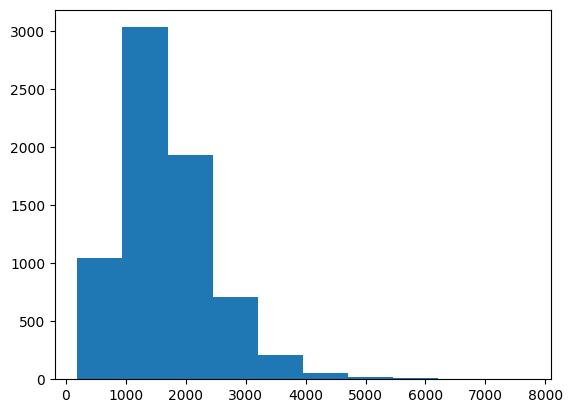

In [34]:
import matplotlib.pyplot as plt

token_len_list = [len(l) for l in train_df.TEXT.str.split()]

plt.hist(token_len_list)
plt.show()

In [40]:
sum(train_df)/len(train_df)

TypeError: unsupported operand type(s) for +: 'int' and 'str'

## Data Import and Preprocessing

In [ ]:
# @dataclass
# class FrameParams:
#     df: pd.DataFrame
#     class_name: str
#     class_val: float


# # function to get the set of unique patient ids in the dataframe
# # then split based on the train/val/test proportion
# def split_ids(id_col, test_prop, validation, seed):
#     # get set of unique ids and convert to a list
#     id_list = list(set(id_col))

#     # shuffle id list
#     random.Random(seed).shuffle(id_list)

#     # get split lengths
#     id_list_len = len(id_list)

#     # get the length of indexes to add to the train/test sets
#     train_prop = 1.0 - (2 * test_prop)
#     train_len = int(train_prop * id_list_len)
#     test_len = int(test_prop * id_list_len)

#     # index set ids
#     if validation:
#         train_ids = id_list[:train_len]
#         val_ids = id_list[train_len:train_len+test_len]

#     else:
#         train_ids = id_list[:train_len+test_len]
#         val_ids = None

#     test_ids = id_list[train_len+test_len:]

#     print('total ids:', id_list_len)

#     print('train ids: {}, prop: {:.3f}'.format(
#         len(train_ids),
#         len(train_ids) / id_list_len
#     ))

#     if validation:
#         print('val ids: {}, prop: {:.3f}'.format(
#             len(val_ids),
#             len(val_ids) / id_list_len
#         ))

#     print('test ids: {}, prop: {:.3f}\n'.format(
#         len(test_ids),
#         len(test_ids) / id_list_len
#     ))

#     return train_ids, val_ids, test_ids

# # function to index pos/neg dataframes by set patient ids and merge them
# def index_dataframes(df_obj_list, ids, id_var):
#     # zip pos/neg dataframes and ids
#     components = zip([df_obj.df for df_obj in df_obj_list], ids)

#     # index dataframes by ids for pos/neg
#     df_list = [df[df[id_var].isin(ids)] for df, ids in components]

#     # merge pos/neg dataframes
#     out_df = pd.concat(df_list, axis=0)
#     return out_df

# # function to split a positive and negative dataframe into train/val/test
# # then merge positive and negative for each
# def split_n_dataframes(df_list, id_var: str = 'tweet_id',
#                        test_prop: float = 0.2, seed: int = 13,
#                        validation: bool = True, label_col: str = 'label'):
#     # add label columns to dataframes
#     for df_obj in df_list:
#         df_obj.df.loc[:, 'class_label'] = df_obj.class_val

#     # get empty list to put dataframe set IDs
#     df_ids = []

#     # get ids for each split dataframe
#     for df_obj in df_list:
#         train_ids, val_ids, test_ids = split_ids(
#             df_obj.df[id_var],
#             test_prop,
#             validation,
#             seed
#         )
#         df_ids.append([train_ids, val_ids, test_ids])

#     # transpose list to get sublists of all train set IDs, val sets IDs, etc.
#     trans_df_ids = [i for i in zip(*df_ids)]

#     # prepare lists for indexing
#     train_ids = trans_df_ids[0]
#     val_ids = trans_df_ids[1]
#     test_ids = trans_df_ids[2]

#     # index split dataframes
#     train_df = index_dataframes(df_list, train_ids, id_var)
#     test_df = index_dataframes(df_list, test_ids, id_var)
#     if validation:
#         val_df = index_dataframes(df_list, val_ids, id_var)

#     # shuffle dataframes
#     train_df = train_df.sample(frac=1, random_state=seed).reset_index()
#     test_df = test_df.sample(frac=1, random_state=seed).reset_index()
#     if validation:
#         val_df = val_df.sample(frac=1, random_state=seed).reset_index()
#     else:
#         val_df = None

#     return train_df, val_df, test_df

In [ ]:
# df_negative = FrameParams(df=df[df['general_sentiment'] == -1], class_name='negative', class_val=0)
# df_neutral = FrameParams(df=df[df['general_sentiment'] == 0], class_name='neutral', class_val=1)
# df_positive = FrameParams(df=df[df['general_sentiment'] == 1], class_name='positive', class_val=2)

# df_list = [df_negative, df_neutral, df_positive]
# train_df, val_df, test_df = split_n_dataframes(df_list, id_var='tweet_id', test_prop=0.2, seed=13, validation=True)

# print('train size:', len(train_df))
# print('val size:', len(val_df))
# print('test size:', len(test_df))

In [ ]:
print(f'\ntrain distribution:\n{train_df.class_label.value_counts(dropna=False, normalize=True)}')
print(f'\nval distribution:\n{val_df.class_label.value_counts(dropna=False, normalize=True)}')
print(f'\ntest distribution:\n{test_df.class_label.value_counts(dropna=False, normalize=True)}')

In [ ]:
print(f'\ntrain distribution:\n{train_df.class_label.value_counts(dropna=False, normalize=False)}')
print(f'\nval distribution:\n{val_df.class_label.value_counts(dropna=False, normalize=False)}')
print(f'\ntest distribution:\n{test_df.class_label.value_counts(dropna=False, normalize=False)}')

In [41]:
class TextDataset(Dataset):
    """
    class is very closely based on the huggingface tutorial implementation
    """
    def __init__(self, dataframe, tokenizer, max_len, target_cols: list[str], id_col: str = 'row_id',
                 text_col: str = 'TEXT'):
        self.tokenizer = tokenizer
        # self.data = dataframe
        self.text_id_list = list(dataframe[id_col])
        self.text_list = list(dataframe[text_col])
        self.label_list = self._get_labels(dataframe, target_cols)
        self.max_len = max_len
        
    def _get_labels(self, dataframe, target_col_list):
        label_list_container = list()
        
        for target_col in target_col_list:
            label_list_container.append(
                list(dataframe[target_col].astype(float))
            )
            
        return list(zip(label_list_container))

    def __len__(self):
        # get length of dataset (required for dataloader)
        return len(self.text_list)

    def __getitem__(self, idx):
        # extract text
        text = str(self.text_list[idx])

        # extract label
        label = self.label_list[idx]

        # tokenize text
        encoded_text = self.tokenizer.encode_plus(
            text,
            # add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )

        # unpack encoded text
        ids = encoded_text['input_ids']
        attention_mask = encoded_text['attention_mask']
        token_type_ids = encoded_text["token_type_ids"]

        # wrap outputs in dict
        out_dict = {
            'text_id_list': self.text_id_list,
            'id_tensor': torch.tensor(ids, dtype=torch.long),
            'mask_tensor': torch.tensor(attention_mask, dtype=torch.long),
            'token_type_tensor': torch.tensor(token_type_ids, dtype=torch.long),
            'label_tensor': torch.tensor(label, dtype=torch.long)
        }

        return out_dict

In [44]:
# load roberta base as a tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

MAX_LEN = 4096

target_col_list = ['alcohol_binary', 'environment_binary', 'community_binary']

# load dataframes into dataset objects
train_ds = TextDataset(
    dataframe=train_df, 
    tokenizer=tokenizer, 
    max_len=MAX_LEN, 
    target_cols=target_col_list
)

In [45]:
def get_dataloader(dataset, batch_size, shuffle: bool = True,
                   pin_memory: bool = True, num_workers: int = 0,
                   prefetch_factor: int or None = None):
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        pin_memory=pin_memory,
        num_workers=num_workers,
        prefetch_factor=prefetch_factor
    )
    return dataloader

BATCH_SIZE = 64

# load datasets into loaders
train_loader = get_dataloader(train_ds, BATCH_SIZE)
# val_loader = get_dataloader(val_ds, BATCH_SIZE)
# test_loader = get_dataloader(test_ds, BATCH_SIZE)

## Instantiate RoBERTa

In [ ]:
class CustomRoberta(torch.nn.Module):
    """
    model subclass to define the RoBERTa architecture, also closely based on
    the huggingface tutorial implementation
    """
    def __init__(self, drop_percent, num_classes, pt_model_name: str = 'roberta-base'):
        super().__init__()
        self.base_model = RobertaModel.from_pretrained(pt_model_name)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(drop_percent)
        self.classifier = torch.nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        # get outputs from base model
        base_outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        # extract hidden state from roberta base outputs
        hidden_state = base_outputs[0]
        x = hidden_state[:, 0]

        # define the linear layer preceding the classifier
        # and apply ReLU activation to its outputs
        x = self.pre_classifier(x)
        x = torch.nn.ReLU()(x)

        # define the dropout layer and classifier
        # and apply Softmax activation to its outputs
        x = self.dropout(x)
        x = self.classifier(x)
        # outputs = torch.nn.Softmax(dim=-1)(x)
        return x #outputs

In [49]:
# define metric collection
# TASK_TYPE = 'binary'
TASK_TYPE = 'multilabel'
NUM_CLASSES = 2
NUM_LABELS = 3

AVERAGE_STRATEGY = 'samplewise'

metric_collection = MetricCollection({
    'acc': Accuracy(task=TASK_TYPE, num_labels=NUM_LABELS, num_classes=NUM_CLASSES, multidim_average=AVERAGE_STRATEGY),
    'auc': AUROC(task=TASK_TYPE, num_labels=NUM_LABELS, num_classes=NUM_CLASSES),
    'prec': Precision(task=TASK_TYPE, num_labels=NUM_LABELS, num_classes=NUM_CLASSES, multidim_average=AVERAGE_STRATEGY),
    'rec': Recall(task=TASK_TYPE, num_labels=NUM_LABELS, num_classes=NUM_CLASSES, multidim_average=AVERAGE_STRATEGY),
    'f1': F1Score(task=TASK_TYPE, num_labels=NUM_LABELS, num_classes=NUM_CLASSES, multidim_average=AVERAGE_STRATEGY)
})

metric_collection.to(device)

NameError: name 'device' is not defined

## Train

In [ ]:
# weight_tensor = torch.Tensor()

LEARNING_RATE = 1e-4

# define loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
loader_dict = {'train': train_loader, 'val': val_loader, 'test': test_loader}

seed_script(SEED)

train_out_tuple = train_model(
    model, 
    loader_dict, 
    metric_collection, 
    criterion, 
    optimizer, 
    save_dir="./gen_sent_model_test_1", 
    num_epochs=40, 
    monitor_metric='val_f1'
)